## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

## 1. Data Loading and Cleaning 
In this step, we load our dataset and perform an initial inspection:
* View general information about the data using `.info()`
* Check for missing values using `.isna().sum()`

In [3]:
data = pd.read_csv(r"D:\\my_projects\\project_gate_AB\\data\\cookie_cats.csv")
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

**Conclusion:**  
The data is clean, with no missing values detected.  
We can now proceed to the Exploratory Data Analysis (EDA) phase.

## 2. Exploratory Data Analysis (EDA)
Now that the data is clean, we'll dive deeper. The first step in analyzing an A/B test is to check if the two groups have a similar number of players.
### 2.1 Checking Group Sizes

In [4]:
group_size = data['version'].value_counts()
print(group_size)

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


**Conclusion on Group Sizes:**
While the number of players in the two groups is not exactly equal, the difference is small and not critical. It is normal for A/B tests to have a slight difference in sample sizes. This confirms the groups are well-balanced enough for a reliable analysis.

### 2.2 Analyzing 'sum_gamerounds'
Let's look at the distribution of the `sum_gamerounds` column, which is a key indicator of player engagement. We'll start by looking at its summary statistics to identify potential skewness or outliers.

In [5]:
data['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

**Observation:** There is a huge difference between the mean (~52) and the median (16), and the max value (49.854) is extremely high compared to the 75th percentile (51). This confirms that the data is highly skewed and there is at least one extreme outlier.

Let's use a box plot to visualize this.

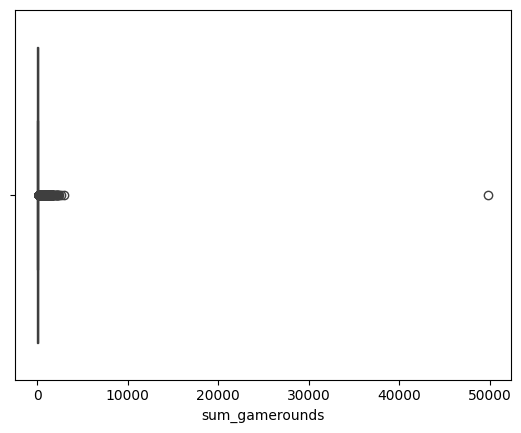

In [6]:
s_game_r = sns.boxplot(x = data['sum_gamerounds'])
plt.show()

The box plot confirms our suspicion: the vast majority of players are clustered at the low end, and there is one extreme data point that skews the entire dataset. This is likely a bug or a test account and should be removed for a meaningful analysis.

In [7]:
data = data[data['sum_gamerounds'] < 40000]
data['sum_gamerounds'].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

After removing the single outlier, the maximum value is now much more reasonable. Let's create another box plot to see the new distribution of our player base.

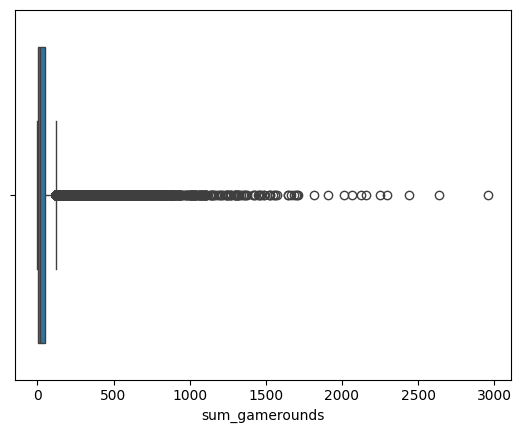

In [8]:
sns.boxplot(x = data['sum_gamerounds'])
plt.show()

### 2.3 Analyzing Player Behavior by Group
The box plot shows a heavily skewed distribution, which is common in gaming data. The "outliers" are not errors but represent our most engaged players. Our goal now is to compare the engagement (`sum_gamerounds`) between the two groups (`gate_30` and `gate_40`).

We can do this by grouping the data by `version` and calculating summary statistics.

In [9]:
data.groupby('version')['sum_gamerounds'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])

,count,mean,median,std,min,max
version,,,,,,
gate_30,44699,51.342111,17.0,102.057598,0,2961
gate_40,45489,51.298776,16.0,103.294416,0,2640


**EDA Conclusion:**

The exploratory data analysis is complete. We have confirmed that the group sizes are balanced and have handled the extreme outlier in `sum_gamerounds`. The dataset is now clean and ready for formal hypothesis testing.

## 3. Hypothesis Formulation

Now that we have cleaned and explored the data, it's time to formally state our hypotheses for the A/B test.

* **Null Hypothesis (H₀):** There is **no difference** in player retention (both 1-day and 7-day) between the two groups (`gate_30` and `gate_40`). Any observed difference is due to random chance.

* **Alternative Hypothesis (H₁):** There is **a significant difference** in player retention (both 1-day and 7-day) between the two groups.

Our goal is to gather statistical evidence to either reject the null hypothesis in favor of the alternative, or fail to reject it.

## 4. Metric Calculation
Now we move to the primary metrics of our A/B test: 1-day and 7-day retention. We will calculate the retention rate for each group. This is simply the average of the boolean retention columns, as `True` values are treated as `1` and `False` values as `0`

In [10]:
retention = data.groupby('version')[['retention_1', 'retention_7']].mean()
print(retention * 100)

         retention_1  retention_7
version                          
gate_30    44.819795    19.018323
gate_40    44.228275    18.200004


**Observation:**

We can see a difference in retention rates for both 1-day and 7-day periods. The `gate_30` group shows a slightly higher retention rate than the `gate_40` group.

The next and final step is to determine if this difference is **statistically significant** or if it's just due to random chance. For this, we will use a statistical test.

## 5. Statistical Testing:
We have observed a difference in the retention rates between our two groups (`gate_30` and `gate_40`). Now, we must determine if this difference is statistically significant or if it's simply due to random chance.
So, we are comparing two categorical variables: the gate `version` (gate_30 vs. gate_40) and player `retention` (True vs. False). The **Chi-squared (χ²) test** is the best option here, as it is designed to compare proportions between two or more categorical groups.

We will use a standard **significance level (alpha) of 0.05**.

In [11]:
alpha = 0.05

First, let's create the contingency table for 1-day retention and calculate the Chi-squared test.

In [12]:
retention_1_table = pd.crosstab(data['version'], data['retention_1'])
print(retention_1_table)

chi2, p_value_1, dof, expected = sp.stats.chi2_contingency(retention_1_table)
print(p_value_1)

retention_1  False  True 
version                  
gate_30      24665  20034
gate_40      25370  20119
0.07500999897705692


Now, let's do the same for 7-day retention

In [13]:
retention_2_table = pd.crosstab(data['version'], data['retention_7'])
print(retention_2_table)

chi2_2, p_value_2, dof_2, expected_2 = sp.stats.chi2_contingency(retention_2_table)
print(p_value_2)


retention_7  False  True 
version                  
gate_30      36198   8501
gate_40      37210   8279
0.0016391259678654425


### Analysis of P-values

Now we have the p-values for both tests. We need to compare them to our significance level of 0.05 to make a conclusion.

In [14]:
print(p_value_1 > alpha)
print(p_value_2 > alpha)

True
False


We have completed our A/B test analysis by performing two Chi-squared tests, one for 1-day retention and one for 7-day retention. Our significance level (alpha) was 0.05.

### Conclusion:

1.  **1-Day Retention:**
    * **P-value:** `0.075`
    * **Conclusion:** Since the p-value is greater than 0.05, we **fail to reject the null hypothesis**. This means there is **no statistically significant difference** in 1-day retention between the `gate_30` and `gate_40` groups. The small difference we observed is likely due to random chance.

2.  **7-Day Retention:**
    * **P-value:** `0.0016`
    * **Conclusion:** Since the p-value is much smaller than 0.05, we **reject the null hypothesis**. This indicates there is **a statistically significant difference** in 7-day retention. The `gate_40` group shows a lower 7-day retention rate, and this is not a random fluctuation.

## 6. Result Visualizing:

Before writing our final recommendation, let's create a visual summary of our findings. We will plot the retention rates for both groups to clearly see the difference in performance.

         retention_1  retention_7
version                          
gate_30     0.448198     0.190183
gate_40     0.442283     0.182000
   version       metric  retention_percent
0  gate_30  retention_1           0.448198
1  gate_30  retention_7           0.190183
2  gate_40  retention_1           0.442283
3  gate_40  retention_7           0.182000


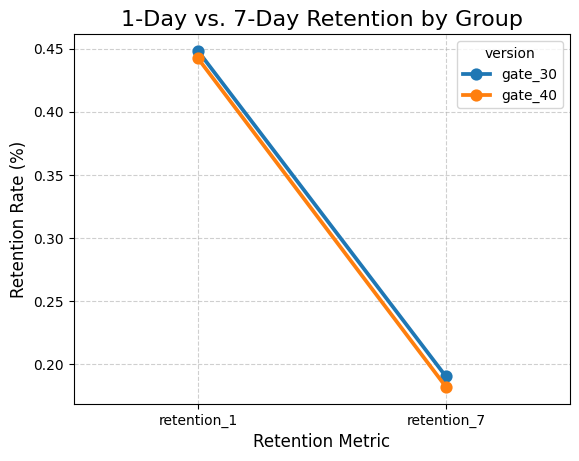

In [38]:
print(retention)
retention_long = retention.stack().rename_axis(['version', 'metric']).reset_index(name= 'retention_percent')
print(retention_long)
sns.pointplot(data=retention_long, x='metric', y='retention_percent', hue='version')
plt.title('1-Day vs. 7-Day Retention by Group', fontsize=16)
plt.ylabel('Retention Rate (%)', fontsize=12)
plt.xlabel('Retention Metric', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This plot clearly visualizes our findings:
* **For `retention_1`:** The two points are extremely close together, visually confirming our p-value (p=0.075) which suggested no significant difference.
* **For `retention_7`:** The points visibly diverge. The line for `gate_30` (blue) is clearly above the line for `gate_40` (orange), which visually represents our statistically significant finding (p=0.0016).

Now we can confidently write our final recommendation.

## 7. Final Conclusion & Recommendation

We have completed our A/B test analysis, and the results are now clear.

### Summary of Findings:

Our statistical analysis yielded two distinct conclusions for our two primary metrics:

1.  **1-Day Retention:** We found **no statistically significant difference** (p = 0.075) between the `gate_30` and `gate_40` groups. This suggests that the gate's position has no immediate, short-term impact on whether a player returns the next day.

2.  **7-Day Retention:** We found a **highly statistically significant difference** (p = 0.0016) between the groups. The data clearly shows that `gate_30` has a higher long-term retention rate than `gate_40`.

### Business Recommendation:

The evidence is clear: while moving the gate from level 30 to level 40 has no significant short-term effect, it has a **statistically significant negative impact** on long-term player retention.

**Therefore, the recommendation is: Do Not Implement the Change.**

The company should **keep the gate at level 30**. The original configuration is more effective at keeping players engaged and returning to the game seven days after installation.